# Calculate and plot 2D lat-lon pathway distributions for each basin under senstivity testing scenarios
- 2Dpxy calculation showing cumulative pathways for particles 

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob

from dask.distributed import Client
import memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [6]:
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [7]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33961/status,
Dashboard: /proxy/33961/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38943,Workers: 6
Dashboard: /proxy/33961/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:35835,Total threads: 3
Dashboard: /proxy/46059/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:36595,


# Transport conservation. 

In this test, half the particles are removed and the 2D pathways and connectivity percentages are recalculated. 

## Calculations

#### Calculate pathways up until last time on shelf using 6 coarse basin regions

Load data for 2Dpxy calculation. 

In [96]:
%%time
# Open Antarctic basins file
antarctic_basins = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')

# Open initial particle parameters file
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ds_iv = xr.open_dataset(startfile, decode_cf=False)

# Define particle files
npart = 130146
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 

## open complete particle dataset
ds = xr.open_mfdataset(files, decode_cf=False).drop_vars(['psal','thermo','mixedlayershuffle',
                                                          'mldepth', 'unbeachCount', 'z', 
                                                          'basin', 'shelf'])#.load()

CPU times: user 2.41 s, sys: 807 ms, total: 3.22 s
Wall time: 7.66 s


Select out every second particle to assess particle transport sensitivity. 

In [97]:
idx = np.arange(0,9500658,2)
ds_iv = ds_iv.isel(trajectory = idx)
ds = ds.isel(trajectory = idx)

Set histogram parameters. 

In [6]:
xstart = -280  # starting longitude
xend = 80      # final longitude
xbinlim = [xstart, xend]  # longitude bin limits
ystart =-81    # starting latitude
yend = -48     # final latitude
ybinlim = [ystart, yend]  # loatitude bin limits
dx_map = 0.5     # x-grid size for 2D pdf maps
dy_map = 0.25   # y-grid size for 2D pdf maps 
xbins = int(360/dx_map)   # number of longitude bins
ybins = int(33/dy_map)    # number of latitude bins
xarange = np.arange(xstart, xend+dx_map, dx_map)
yarange = np.arange(ystart, yend+dy_map, dy_map)
xmid = (xarange[1:]+xarange[:-1])/2. # longitude midpoints
ymid = (yarange[1:]+yarange[:-1])/2. # latitude midpoints

Now calculate 2D particle distribution in x and y space for each coarse basin region. 

In [7]:
%%time

for basinid in antarctic_basins.basin_lookup[2:]:
    print(basinid.values)
    traj = np.where(ds_iv.basin == basinid.values)[0] # find trajectories that start in this basin
    #dsloop = ds[dict(trajectory=traj)].load()        # load particle data for specific basin
    print("Loading dataset...")
    dsloop = ds.isel(trajectory=traj).load()          # load particle data for specific basin
    ds_iv_t = ds_iv.trans[traj].load()                # load particle transport
    ds_iv_tidx = ds_iv.shelf_exit_indx[traj].load()   # load particle tidx
    print("~ Array size (GB):", dsloop.nbytes/1000**3, "Number of particles:", len(dsloop.lon[0,:]))
    
    #array to store binned particle counts from origin to final location
    in_box = np.zeros((xbins,ybins))
    in_box_trans = np.zeros((xbins,ybins))

    for n in np.arange(dsloop.lon.shape[1]):
        if n % 50000 == 0:
            print(n)
        t = int(ds_iv_tidx[n].values)    # last time on shelf
        x = dsloop.lon[:t+1,n]           # longitude of particle n up to last time on shelf
        y = dsloop.lat[:t+1,n]           # latitude of particle n up to last time on shelf
        H = np.histogram2d(x,y,[xbins,ybins],[xbinlim,ybinlim])
        boxind = np.nonzero(H[0])
        in_box[boxind[0],boxind[1]] = in_box[boxind[0],boxind[1]]+1  # count
        in_box_trans[boxind[0],boxind[1]] = in_box_trans[boxind[0],boxind[1]]+1*np.abs(ds_iv_t[n]).values  # transport weighted

    # create 2D pathways matrices
    pxy_pathway_pct = 100.*np.float64(in_box)/np.float64(dsloop.lon.shape[1]) # percentage count
    pxy_pathway_trans = np.float64(in_box_trans)                              # transport weighted
    pxy_pathway_trans_pct = 100.*np.float64(in_box_trans)/np.float64(np.sum(np.abs(ds_iv_t)))   # percentage transport weighted
    
    # convert to DataArrays
    pxy_pct = xr.DataArray(data = pxy_pathway_pct, dims=["lon", "lat"], coords = {"lat": ymid, "lon": xmid})
    pxy_transport = xr.DataArray(data = pxy_pathway_trans, dims=["lon", "lat"], coords = {"lat": ymid, "lon": xmid})
    pxy_transport_pct = xr.DataArray(data = pxy_pathway_trans_pct, dims=["lon", "lat"], coords = {"lat": ymid, "lon": xmid})
    pxy_pct = pxy_pct.where(pxy_pct>0, np.nan)
    pxy_transport = pxy_transport.where(pxy_transport>0, np.nan)
    pxy_transport_pct = pxy_transport_pct.where(pxy_transport_pct>0, np.nan)

    # Combined into one Dataset
    pxy = xr.Dataset({"pxy_pct": pxy_pct, "pxy_trans": pxy_transport, "pxy_trans_pct": pxy_transport_pct})
    
    # save to file
    outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
    outfile = outdir + 'sensitivityTest_2Dpxy_basin_{:02d}_0.5x0.25.nc'.format(int(basinid.values))
    
    # Save to netCDF
    print("Saving to netCDF file", outfile)
    encod={}
    for var in pxy.data_vars:
        encod[var]={'zlib':True}
    pxy.to_netcdf(outfile)

4.0
Loading dataset...
~ Array size (GB): 20.095117764 Number of particles: 1106315
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/sensitivityTest_2Dpxy_basin_04_0.5x0.25.nc
5.0
Loading dataset...
~ Array size (GB): 21.435675456 Number of particles: 1180118
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/sensitivityTest_2Dpxy_basin_05_0.5x0.25.nc
6.0
Loading dataset...
~ Array size (GB): 1.09791692 Number of particles: 60444
0
50000
Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/sensitivityTest_2Dpxy_basin_06_0.5x0.25.nc
7.0
Loading dataset...
~ Array size (GB): 22.290927

## Bar chart data

In [8]:
# Define particle files
npart = 130146
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/xarray_files/traj_chunked_basin/'
files = sorted(glob(datadir+'CircumAntarcticParticles_*.nc')) 

## open complete particle dataset
ds = xr.open_mfdataset(files, decode_cf=False).drop_vars(['psal','thermo','mixedlayershuffle',
                                                          'mldepth', 'unbeachCount', 'z', 
                                                          'basin_ZonalConn','shelf'])#.load()
idx = np.arange(0,9500658,2)
ds = ds.isel(trajectory = idx)
ds

<xarray.Dataset>
Dimensions:     (time: 1513, trajectory: 4750329)
Coordinates:
  * time        (time) float64 0.0 4.32e+05 8.64e+05 ... 6.528e+08 6.532e+08
  * trajectory  (trajectory) float64 0.0 2.0 4.0 ... 9.657e+06 9.657e+06
Data variables:
    lat         (time, trajectory) float32 dask.array<chunksize=(1513, 65073), meta=np.ndarray>
    lon         (time, trajectory) float32 dask.array<chunksize=(1513, 65073), meta=np.ndarray>
    basin       (time, trajectory) float32 dask.array<chunksize=(1513, 65073), meta=np.ndarray>

In [9]:
# set up array for time from each basin. 
l = len(antarctic_basins.basin_lookup[0:-1])
basin_count = np.zeros((l,l))
basin_count = xr.DataArray(basin_count, coords=[antarctic_basins.region[0:-1], antarctic_basins.region[0:-1]], dims=["source_region", "downstream_region"])
trans_count = np.zeros((l,l))
basin_trans_pct = xr.DataArray(trans_count, coords=[antarctic_basins.region[0:-1], antarctic_basins.region[0:-1]], dims=["source_region", "downstream_region"])

In [10]:
# loop through the basins and calculate count and % transport that reaches downstream shelf regions
for j in range(len(basin_count.source_region)):
    basinid = antarctic_basins.basin_lookup.sel(region=basin_count.source_region[j].values).values
    print(j, basin_count.source_region[j].values, basinid)
    traj = np.unique(np.where(ds_iv.basin == basinid))

    # extract only trajectories that originate in specific source region 
    dsbasin = ds.basin[:,traj]#.load()
    transbasin = ds_iv.trans[traj]
    transtot = np.abs(transbasin).sum()

    # Now loop through downstream regions and find how many particles make it there
    for k in range(len(basin_count.downstream_region)):
        print("Downstream region:", k, basin_count.downstream_region[k].values)
        basinid_downstream = antarctic_basins.basin_lookup.sel(region=basin_count.downstream_region[k].values).values

        # Find number of unique particles that make it to specific downstream region
        traj_downstream = np.unique(np.where(dsbasin[:,:] == basinid_downstream)[1])
        basin_count[j,k] = len(traj_downstream)
        trans_downstream = transbasin[traj_downstream]
        basin_trans_pct[j,k] = np.abs(trans_downstream).sum()/transtot*100

0 East Antarctica 01 2.0
Downstream region: 0 East Antarctica 01
Downstream region: 1 East Antarctica 02
Downstream region: 2 Ross Sea
Downstream region: 3 West Antarctica
Downstream region: 4 West Antarctic Peninsula
Downstream region: 5 Weddell Sea
1 East Antarctica 02 3.0
Downstream region: 0 East Antarctica 01
Downstream region: 1 East Antarctica 02
Downstream region: 2 Ross Sea
Downstream region: 3 West Antarctica
Downstream region: 4 West Antarctic Peninsula
Downstream region: 5 Weddell Sea
2 Ross Sea 4.0
Downstream region: 0 East Antarctica 01
Downstream region: 1 East Antarctica 02
Downstream region: 2 Ross Sea
Downstream region: 3 West Antarctica
Downstream region: 4 West Antarctic Peninsula
Downstream region: 5 Weddell Sea
3 West Antarctica 5.0
Downstream region: 0 East Antarctica 01
Downstream region: 1 East Antarctica 02
Downstream region: 2 Ross Sea
Downstream region: 3 West Antarctica
Downstream region: 4 West Antarctic Peninsula
Downstream region: 5 Weddell Sea
4 West An

In [11]:
# Combine into one Dataset
data = xr.Dataset({"basin_count": basin_count, 
                      #"basin_trans": basin_trans, 
                      "basin_trans_pct": basin_trans_pct})
data.basin_count.attrs["Name"] = "Number of particles from source_region that make it into down_stream region"
data.basin_trans_pct.attrs["Name"] = "Percentage of transport from source_region that reaches down_stream region"
data.attrs["Sensitivity_test"] = "Half release [every second particle]"
data

<xarray.Dataset>
Dimensions:            (source_region: 6, downstream_region: 6)
Coordinates:
  * source_region      (source_region) object 'East Antarctica 01' ... 'Wedde...
  * downstream_region  (downstream_region) object 'East Antarctica 01' ... 'W...
Data variables:
    basin_count        (source_region, downstream_region) float64 5.503e+05 ....
    basin_trans_pct    (source_region, downstream_region) float64 100.0 ... 1...
Attributes:
    Sensitivity_test:  Half release [every second particle]

In [12]:
# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
outfile = outdir + 'sensitivityTest_BarChartData_coarse_basins.nc'

# Save to netCDF
print("Saving to netCDF file", outfile)
encod={}
for var in data.data_vars:
    encod[var]={'zlib':True}
data.to_netcdf(outfile)

Saving to netCDF file /g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/sensitivityTest_BarChartData_coarse_basins.nc


## Figure

In [98]:
import cmocean as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [99]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

land_mask_masked = land_mask.where(land_mask == 1)
land_mask_contour = land_mask.copy(deep=True)
# remove islands
land_mask_contour[300:, 800:1000] = 0
land_mask_contour[355:,5:140] = 0
land_mask_contour[225:, 1800:2000] = 0
land_mask_contour[281:286, 2100:2128] = 0
land_mask_contour[335:348, 2123:2128] = 0
land_mask_contour[345:360, 2123:2138] = 0
land_mask_contour[360:368, 2143:2152] = 0
land_mask_contour[367:371, 2148:2158] = 0
land_mask_contour[360:380, 2130:2150] = 0
land_mask_contour[356:380, 2130:2145] = 0 
land_mask_contour[392:415, 2171:2182] = 0 
land_mask_contour[160:, 1700:1760] = 0
land_mask_contour[250:300, 2000:2065] = 0
land_mask_contour[382:400, 2150:2167] = 0 
land_mask_contour[385:400, 2167:2169] = 0
land_mask_contour[387:400, 2169:2172] = 0 
land_mask_contour[388:408, 2215:2260] = 0
land_mask_contour[405:411, 2218:2260] = 0
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0

Ncontour = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/input/proj01/sea_level_contour_ryf9091_N_cutoff.nc')
basin_mask = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')
basin_mask['basins'] = basin_mask.basins.where(basin_mask.basins != 100, np.nan)
#plotmask01 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_02_EA01.nc')
#plotmask02 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_03_EA02.nc')
#plotmask03 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_04_Ross.nc')
#plotmask04 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_05_WA.nc')
#plotmask05 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_06_WAP.nc')
#plotmask06 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_07_Weddell.nc')

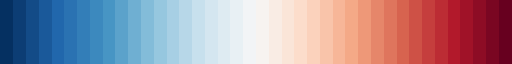

In [100]:
cmapD = plt.cm.RdBu_r._resample(40)
cmapD

In [101]:
# Load 2Dpxy data
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
#files = sorted(glob(datadir+'2Dpxy_basin_*.nc')) 
files = sorted(glob(datadir+'2Dpxy_basin_*_0.5x0.25.nc'))
sensitivity_files = sorted(glob(datadir+'sensitivityTest_2Dpxy_basin_*_0.5x0.25.nc'))

# read in bar chart data
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
outfile = outdir + 'BarChartData_coarse_basins.nc'
data = xr.open_dataset(outfile)
outfile = outdir + 'sensitivityTest_BarChartData_coarse_basins.nc'
sensitivity_data = xr.open_dataset(outfile)

# Open Antarctic basins file
antarctic_basins = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')

Figure parameters. 

In [102]:
colors = ['k', 'k', 'k', 'k', 'k']
regions = ['EA-W', 'EA-E', 'RS', 'WA', 'WAP', 'WS']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']
subplot_labels = ['a)', 'b)', 'c)','d)', 'e)']
col_contour = 'blueviolet'#
maskc = 'blueviolet'#
basincol = 'r'
basinalph = 0.6
alph = 0.3
minpct = 0.0025
maxpct = 0.15
lw = 1.5
subplot_labels = ['a) East Antarctica W', 'b) East Antarctica E', 'c) Ross Sea','d) West Antarctica', 'e) Weddell Sea']

Define figure functions. 

In [103]:
def mercator_plot(axes, extent, xticks, yticks):
    '''
    Return Antarctic Mercator plot on axes
    '''   
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='dimgrey', linewidths=1.4, zorder=3, alpha = 0.9, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    axes.set_xticks(xticks, crs=ccrs.PlateCarree())
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.xaxis.set_major_formatter(LongitudeFormatter())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='x',labelsize=11)
    axes.tick_params(axis='y',labelsize=11)

def add_region_labels(ax1, ax3, ax5, ax7, ax9):
    ax1.text(0.01, 0.9, 'Weddell Sea', fontsize=14, transform=ax1.transAxes)
    ax3.text(0.01, 0.9, 'West Antarctica', fontsize=14, transform=ax3.transAxes)
    ax5.text(0.01, 0.9, 'Ross Sea', fontsize=14, transform=ax5.transAxes)
    ax7.text(0.01, 0.9, 'East Antarctica - East', fontsize=14, transform=ax7.transAxes)
    ax9.text(0.72, 0.9, 'East Antarctica - West', fontsize=14, transform=ax9.transAxes)
    return

def add_subplot_labels(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10):
    ax1.text(-0.09, 0.9, labels[0], fontweight='bold', fontsize=16, transform=ax1.transAxes)
    ax2.text(-0.22, 0.9, labels[5], fontweight='bold', fontsize=16, transform=ax2.transAxes)
    ax3.text(-0.09, 0.9, labels[1], fontweight='bold', fontsize=16, transform=ax3.transAxes)
    ax4.text(-0.22, 0.9, labels[6], fontweight='bold', fontsize=16, transform=ax4.transAxes)
    ax5.text(-0.09, 0.9, labels[2], fontweight='bold', fontsize=16, transform=ax5.transAxes)
    ax6.text(-0.22, 0.9, labels[7], fontweight='bold', fontsize=16, transform=ax6.transAxes)
    ax7.text(-0.09, 0.9, labels[3], fontweight='bold', fontsize=16, transform=ax7.transAxes)
    ax8.text(-0.22, 0.9, labels[8], fontweight='bold', fontsize=16, transform=ax8.transAxes)
    ax9.text(-0.09, 0.9, labels[4], fontweight='bold', fontsize=16, transform=ax9.transAxes)
    ax10.text(-0.22, 0.9, labels[9], fontweight='bold', fontsize=16, transform=ax10.transAxes)
    return

def contour_release_sector(ax1, ax3, ax5, ax7, ax9):
    ax1.contour(xu_ocean[2180:2700], yu_ocean[:395], land_mask_contour[:395,2180:2700].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2203:2300], yu_ocean[394:408], land_mask_contour[394:408,2203:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2214:2300], yu_ocean[408:418], land_mask_contour[408:418,2214:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2235:2300], yu_ocean[418:426], land_mask[418:426,2235:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax3.contour(xu_ocean[1431:2179], yu_ocean[:400], land_mask_contour[:400,1431:2179].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax5.contour(xu_ocean[820:1430], yu_ocean[:223], land_mask[:223,820:1430].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax7.contour(xu_ocean[140:920], yu_ocean[225:], land_mask[225:,140:920].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[2700:], yu_ocean, land_mask[:,2700:].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[0:140], yu_ocean, land_mask[:,0:140].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    
def plot_barchart_pct_labels(ax2, ax4, ax6, ax8, ax10):
    if weight == 1:
        # plt histogram percentages
        ax2.text(0.0826, 0.042, '1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.216, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.374, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.548, 0.08, '5%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.6908, 0.62, '63%', fontweight='normal', fontsize=11, transform=ax2.transAxes)

        ax4.text(0.066, 0.14, '13%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.216, 0.33, '33%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.376, 0.676, '68%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.694, 0.13, '12%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.867, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax4.transAxes)

        ax6.text(0.066, 0.13, '12%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.218, 0.37, '37%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.532, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.702, 0.06, '3%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.866, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax6.transAxes)

        ax8.text(0.06, 0.63, '64%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.373, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.53, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.69, 0.18, '17%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.842, 0.21, '20%', fontweight='normal', fontsize=11, transform=ax8.transAxes)

        ax10.text(0.22, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.375, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.546, 0.05, '2%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.693, 0.43, '43%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.849, 0.54, '54%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
    else:
        ax2.text(0.0826, 0.042, '2%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.218, 0.03, ' 1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.376, 0.03, ' 1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.548, 0.1, '8%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.6908, 0.66, '67%', fontweight='normal', fontsize=11, transform=ax2.transAxes)

        ax4.text(0.066, 0.14, '13%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.216, 0.33, '33%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.376, 0.676, '69%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.697, 0.145, '14%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.867, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax4.transAxes)

        ax6.text(0.066, 0.162, '15%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.218, 0.467, '46%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.532, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.702, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.866, 0.06, '5%', fontweight='normal', fontsize=11, transform=ax6.transAxes)

        ax8.text(0.06, 0.68, '69%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.373, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.53, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.69, 0.198, '19%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.842, 0.228, '22%', fontweight='normal', fontsize=11, transform=ax8.transAxes)

        ax10.text(0.22, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.375, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.546, 0.05, '2%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.693, 0.432, '44%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.849, 0.556, '57%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
    return

def plot_releasesector_label(ax2, ax4, ax6, ax8, ax10):
    ax2.text(0.875, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax2.transAxes, rotation=90)
    ax4.text(0.56, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax4.transAxes, rotation=90)
    ax6.text(0.406, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax6.transAxes, rotation=90)
    ax8.text(0.247, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax8.transAxes, rotation=90)
    ax10.text(0.088, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax10.transAxes, rotation=90)
    return

def plot_axis_ticks_labels(ax2, ax4, ax6, ax8, ax10):
    ax2.set_ylabel('Connectivity (%)', fontsize=13)
    ax4.set_ylabel('Connectivity (%)', fontsize=13)
    ax6.set_ylabel('Connectivity (%)', fontsize=13)
    ax8.set_ylabel('Connectivity (%)', fontsize=13)
    ax10.set_ylabel('Connectivity (%)', fontsize=13)
    ax2.tick_params(axis='y',labelsize=13)
    ax2.set_xticks([])
    ax2.grid(c='gainsboro')
    ax4.tick_params(axis='y',labelsize=13)
    ax4.set_xticks([])
    ax4.grid(c='gainsboro')
    ax6.tick_params(axis='y',labelsize=13)
    ax6.set_xticks([])
    ax6.grid(c='gainsboro')
    ax8.tick_params(axis='y',labelsize=13)
    ax8.set_xticks([])
    ax8.grid(c='gainsboro')
    ax10.tick_params(axis='y',labelsize=13)
    ax10.grid(axis='y', c='gainsboro')
    ax10.tick_params(axis='x',labelsize=13)
    #ax10.set_xticklabels(labels = regions, rotation=90, ha='center', va='top')
    ax10.set_xticklabels(labels = ['\nEast Antarctica\n-West','\nEast Antarctica\n-East', 'Ross Sea',
                                   'West \nAntarctica','Antarctica\nPeninsula','Weddell \nSea'], 
                         rotation=90, ha='center', va='top')  


def plot_barchart_arrows(ax2, ax4, ax6, ax8, ax10):
    ax2.annotate('',xy=(0.4, 0.9), xytext=(0.8, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax4.annotate('',xy=(0.1, 0.9), xytext=(0.5, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax4.annotate('',xy=(0.78, 0.9), xytext=(0.65, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax6.annotate('',xy=(0.1, 0.9), xytext=(0.34, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax6.annotate('',xy=(0.87, 0.9), xytext=(1.005, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax8.annotate('',xy=(0.07, 0.9), xytext=(0.17, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax8.annotate('',xy=(0.75, 0.9), xytext=(1.01, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax10.annotate('',xy=(0.0, 0.9), xytext=(0.04, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', headlength=0,width=4),
                 horizontalalignment='right', verticalalignment='top')
    ax10.annotate('',xy=(0.6, 0.9), xytext=(1.02, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    return

def plot_bars(ax, data, n):
    if weight == 1:
        barlist = ax.bar(data.source_region, data.basin_trans_pct[n,:], color=colors, alpha=0.9, zorder=2)
        barlist[n].set_color('none')
        ax.bar(data.source_region[n], data.basin_trans_pct[n,n], edgecolor='k', color='w', zorder=2)
    else:
        barlist = ax.bar(data.source_region, data.basin_count[n,:]/data.basin_count[n,:].max()*100, 
                         color=colors, alpha=0.9, zorder=2)
        barlist[n].set_color('none')
        ax.bar(data.source_region[n], data.basin_count[n,n]/data.basin_count[n,:].max()*100, 
               edgecolor='k', color='w', zorder=2)
    
def plot_pxy(ax, ds):
    if weight == 1:
        pxy = ds.pxy_trans_pct
    else: 
        pxy = ds.pxy_pct
    pxy = pxy.where(pxy>=minpct, np.nan)
    pxy = pxy/100.
    p1 = ax.pcolormesh(ds.lon, ds.lat, pxy.T, cmap = cmapB, vmin=minpct, vmax=maxpct, zorder=0,transform=ccrs.PlateCarree())
    return p1

def plot_pxy_diff(ax, ds_mod, ds_og):
    mindiffpct, maxdiffpct = -0.15,0.15
    if weight == 1:
        pxy = (ds_mod.pxy_trans_pct - ds_og.pxy_trans_pct)
    else: 
        pxy = (ds_mod.pxy_pct - ds_og.pxy_pct)
    #pxy = pxy.where(pxy>=minpct, np.nan)
    #pxy = pxy/100.
    p1 = ax.pcolormesh(ds_mod.lon, ds_mod.lat, pxy.T, cmap=cmapD, vmin=mindiffpct, vmax=maxdiffpct, zorder=0,transform=ccrs.PlateCarree())
    return p1

def add_colorbar(shading):
    # Add a colorbar axis at bottom of figure
    cbar_ax = fig.add_axes([0.179, 0.1, 0.473, 0.015])
    # Draw the colorbar
    cbar=fig.colorbar(shading, cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.set_ticks([minpct, 0.05, .1, .15])#, rotation=270)
    cbar.set_ticklabels([minpct, .05, .10, .15])#, rotation=270)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def add_colorbar_diff(shading):
    # Add a colorbar axis at bottom of figure
    cbar_ax = fig.add_axes([0.179, 0.086, 0.473, 0.015])
    # Draw the colorbar
    cbar=fig.colorbar(shading, cax=cbar_ax,orientation='horizontal', extend='both')
    #cbar.set_ticks([minpct, 0.05, .1, .15])#, rotation=270)
    #cbar.set_ticklabels([minpct, .05, .10, .15])#, rotation=270)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def figure():
    fig = plt.figure(constrained_layout=True, figsize=(18,18))
    spec1 = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)
    ax1 = fig.add_subplot(spec1[0, 0:3], projection=ccrs.Mercator(central_longitude=-40))
    ax2 = fig.add_subplot(spec1[0, 3], )
    ax3 = fig.add_subplot(spec1[1,0:3], projection=ccrs.Mercator(central_longitude=-100))
    ax4 = fig.add_subplot(spec1[1,3], )
    ax5 = fig.add_subplot(spec1[2,0:3], projection=ccrs.Mercator(central_longitude=180))
    ax6 = fig.add_subplot(spec1[2,3], )
    ax7 = fig.add_subplot(spec1[3,0:3], projection=ccrs.Mercator(central_longitude=120))
    ax8 = fig.add_subplot(spec1[3,3], )
    ax9 = fig.add_subplot(spec1[4,0:3], projection=ccrs.Mercator(central_longitude=90))
    ax10= fig.add_subplot(spec1[4,3], )
    fig.subplots_adjust(wspace=0, hspace=0.06)
    
    ## Map columns
    # Subplot a) ---------------------------------------------------------------------
    xticks = [-100, -70, -40, -10, 20, 50]
    yticks = [-78, -74, -70, -66, -62,]
    mercator_plot(ax1, [-110, 70, -78, -59.5], xticks, yticks)
    ax1.tick_params(axis="x",direction="in", pad=-20)
    # Subplot b) ---------------------------------------------------------------------
    xticks = [-230, -200, -170, -140, -110, -80]
    yticks = [-78, -74, -70, -66, -62] 
    mercator_plot(ax3, [-239, -59, -78.2, -60], xticks, yticks)
    ax3.tick_params(axis="x",direction="in", pad=-20)
    # Subplot c) ---------------------------------------------------------------------
    xticks = [70, 100, 130, 160, 190, 220,]
    yticks = [-78, -74, -70, -66, -62]
    mercator_plot(ax5, [60, 240, -78.5, -60.6], xticks, yticks)
    ax5.tick_params(axis="x",direction="in", pad=-20)
    # Subplot d) ---------------------------------------------------------------------
    xticks = [10, 40, 70, 100, 130, 160, ]
    yticks = [-76, -72, -68, -64, -60, -56] 
    yticks = [-72, -68, -64, -60, -56] 
    mercator_plot(ax7, [-5, 175, -76.1, -54.6], xticks, yticks)
    ax7.tick_params(axis="x",direction="in", pad=-20)
    # Subplot e) ---------------------------------------------------------------------
    xticks = [-60, -30, 0, 30, 60, 90]
    yticks = [-78, -74, -70, -66, -62, ]
    mercator_plot(ax9, [-80, 100, -78, -59.2], xticks, yticks)
    ax9.tick_params(axis="x",direction="in", pad=-20)
    
    # contour release sectors
    contour_release_sector(ax1, ax3, ax5, ax7, ax9)
    # add release sector legend
    release_line = Line2D([0], [0], color=basincol, alpha=0.8, lw=lw)
    ax1.legend([release_line], ['Release sector'], loc='lower right', fontsize=14, bbox_to_anchor=[0.95, 0.2], framealpha=0.5, fancybox=True)
    
    add_region_labels(ax1, ax3, ax5, ax7, ax9)
    
    ## Bar chart columns
    plot_barchart_pct_labels(ax2, ax4, ax6, ax8, ax10)
    plot_barchart_arrows(ax2, ax4, ax6, ax8, ax10)
    plot_releasesector_label(ax2, ax4, ax6, ax8, ax10)
    plot_axis_ticks_labels(ax2, ax4, ax6, ax8, ax10)
    
    ## General
    add_subplot_labels(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10)
    
    return fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)

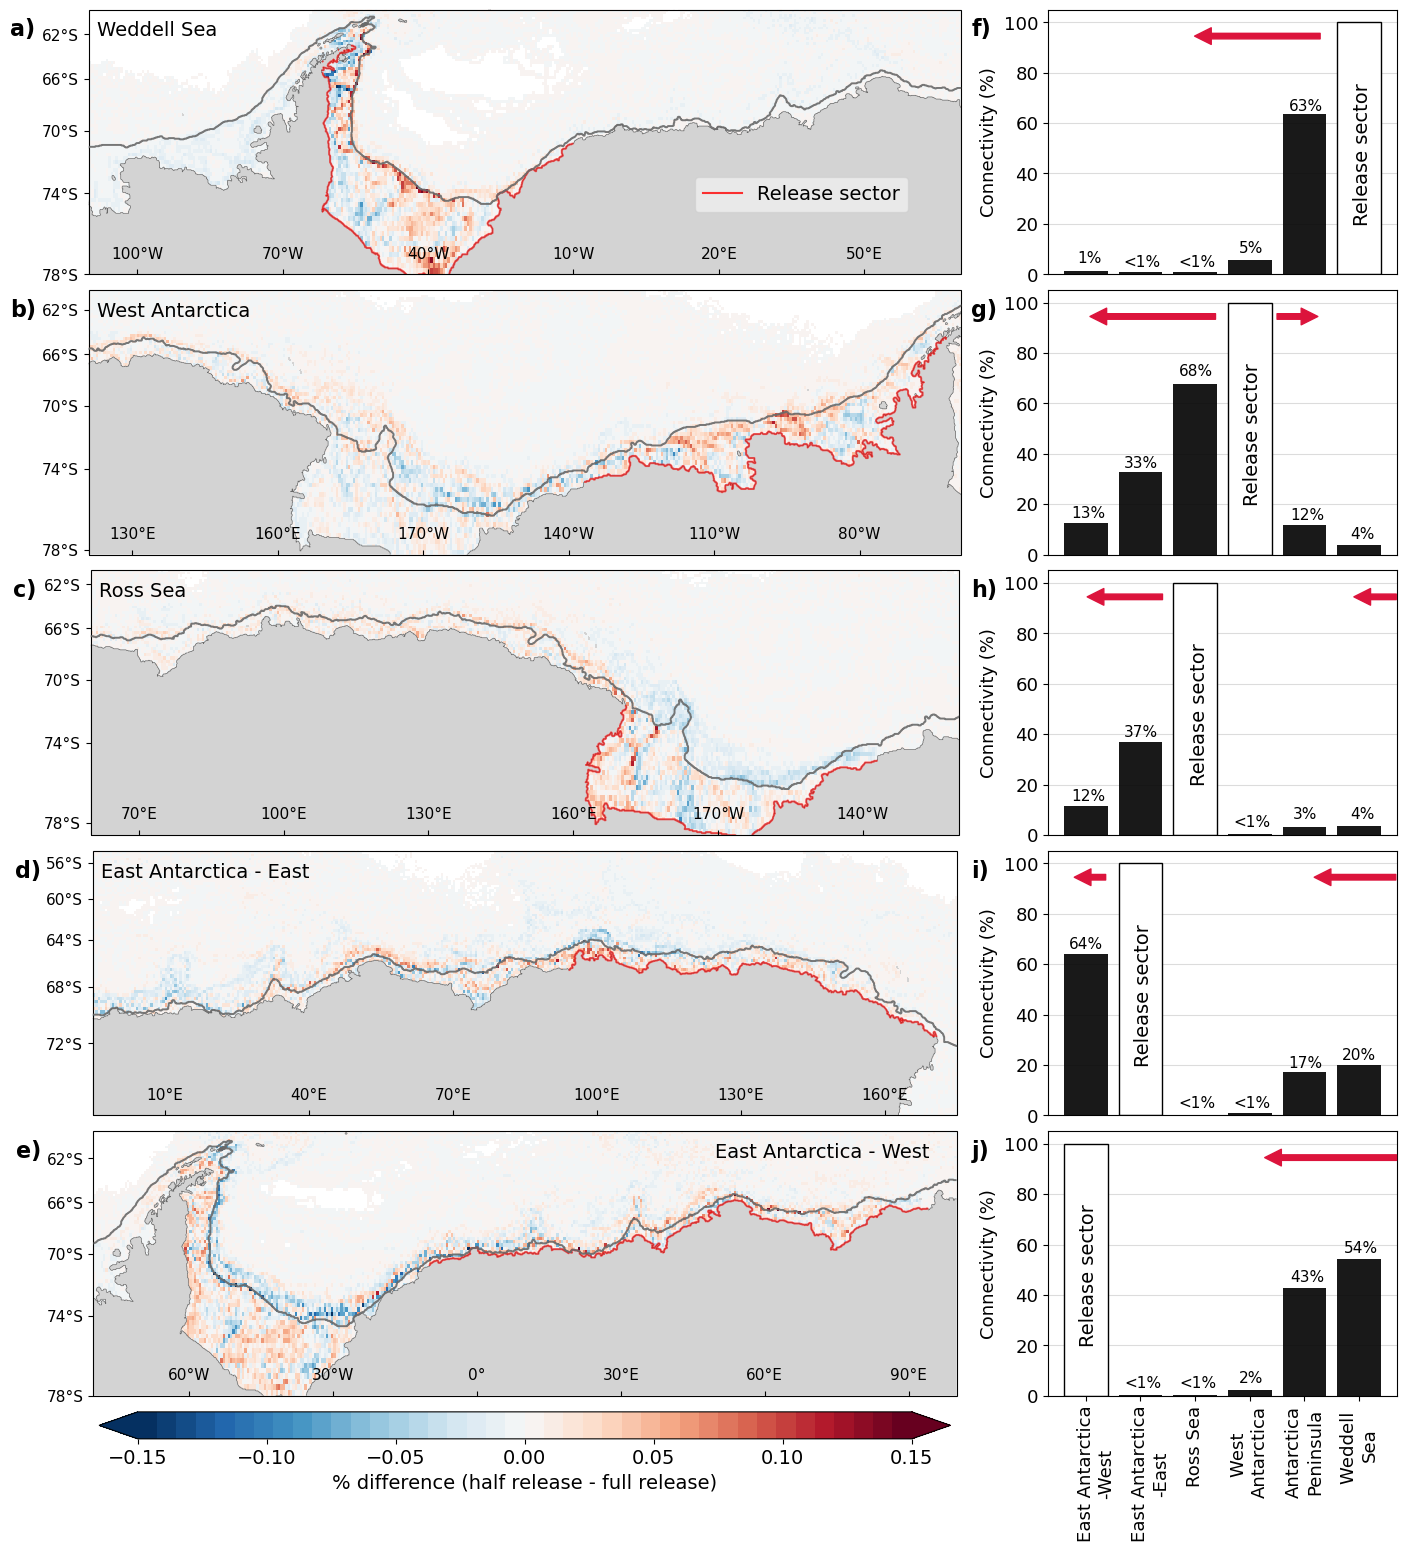

In [104]:
weight = 1  # weighting boolean to indicate transport weighting (or not)
            # 1 = particle count weighted by transport value to account for differing size of grid cells
            # 0 = simple particle count

fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = figure()

## Read in and plot data
# Subplot a) & f)----------------------------------------------------------------  
n = 5
ds_mod = xr.open_dataset(sensitivity_files[n])
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax1, ds_mod, ds)
plot_bars(ax2, sensitivity_data, n)

# Subplot b) & g)----------------------------------------------------------------  
n = 3
ds_mod = xr.open_dataset(sensitivity_files[n])
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax3, ds_mod,ds)
plot_bars(ax4, sensitivity_data, n)

# Subplot c) & h)----------------------------------------------------------------  
n = 2
ds_mod = xr.open_dataset(sensitivity_files[n])
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax5, ds_mod, ds)
plot_bars(ax6, sensitivity_data, n)

# Subplot d) & i)----------------------------------------------------------------  
n = 1
ds_mod = xr.open_dataset(sensitivity_files[n])
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax7, ds_mod, ds)
plot_bars(ax8, sensitivity_data, n)
    
# Subplot e) & j)---------------------------------------------------------------- 
n = 0
ds_mod = xr.open_dataset(sensitivity_files[n])
ds = xr.open_dataset(files[n])
p1 = plot_pxy_diff(ax9, ds_mod, ds)
plot_bars(ax10, sensitivity_data, n)

cbar = add_colorbar_diff(p1)
if weight == 1:
    cbar.set_label('% difference (half release - full release)', fontsize=14)#, rotation=270)
else:
    cbar.set_label('% difference (half release - full release)', fontsize=14)#, rotation=270)


## Save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'sensitivityTest_Fig04_0.5x0.25map_transweight.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

In [105]:
for n in range(5):
    ds_mod = xr.open_dataset(sensitivity_files[n])
    ds = xr.open_dataset(files[n])
    print((ds_mod.pxy_trans_pct - ds.pxy_trans_pct).min().values,(ds_mod.pxy_trans_pct - ds.pxy_trans_pct).max().values)

-0.22460434932621354 0.16642885786263495
-0.12873794802342786 0.12085277520163107
-0.09629062190403648 0.12682602921442232
-0.09296720630749711 0.11446079759833161
-0.20969482491088698 0.47245973040435985


Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-01-17 14:51:21,363 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-17 14:51:21,363 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-17 14:51:21,362 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-17 14:51:21,363 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2023-01-17 14:51:21,363 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    sel

# Transport weighting vs none.


In this test, transport weighting is removed and the 2D pathways and connectivity percentages are recalculated. 

In [94]:
def plot_pxy_diff(ax, ds):
    mindiffpct, maxdiffpct = -4,4
    pxy = (ds.pxy_pct - ds.pxy_trans_pct)
    #pxy = pxy.where(pxy>=minpct, np.nan)
    #pxy = pxy/100.
    p1 = ax.pcolormesh(ds.lon, ds.lat, pxy.T, cmap=cmapD, vmin=mindiffpct, vmax=maxdiffpct, zorder=0,transform=ccrs.PlateCarree())
    return p1

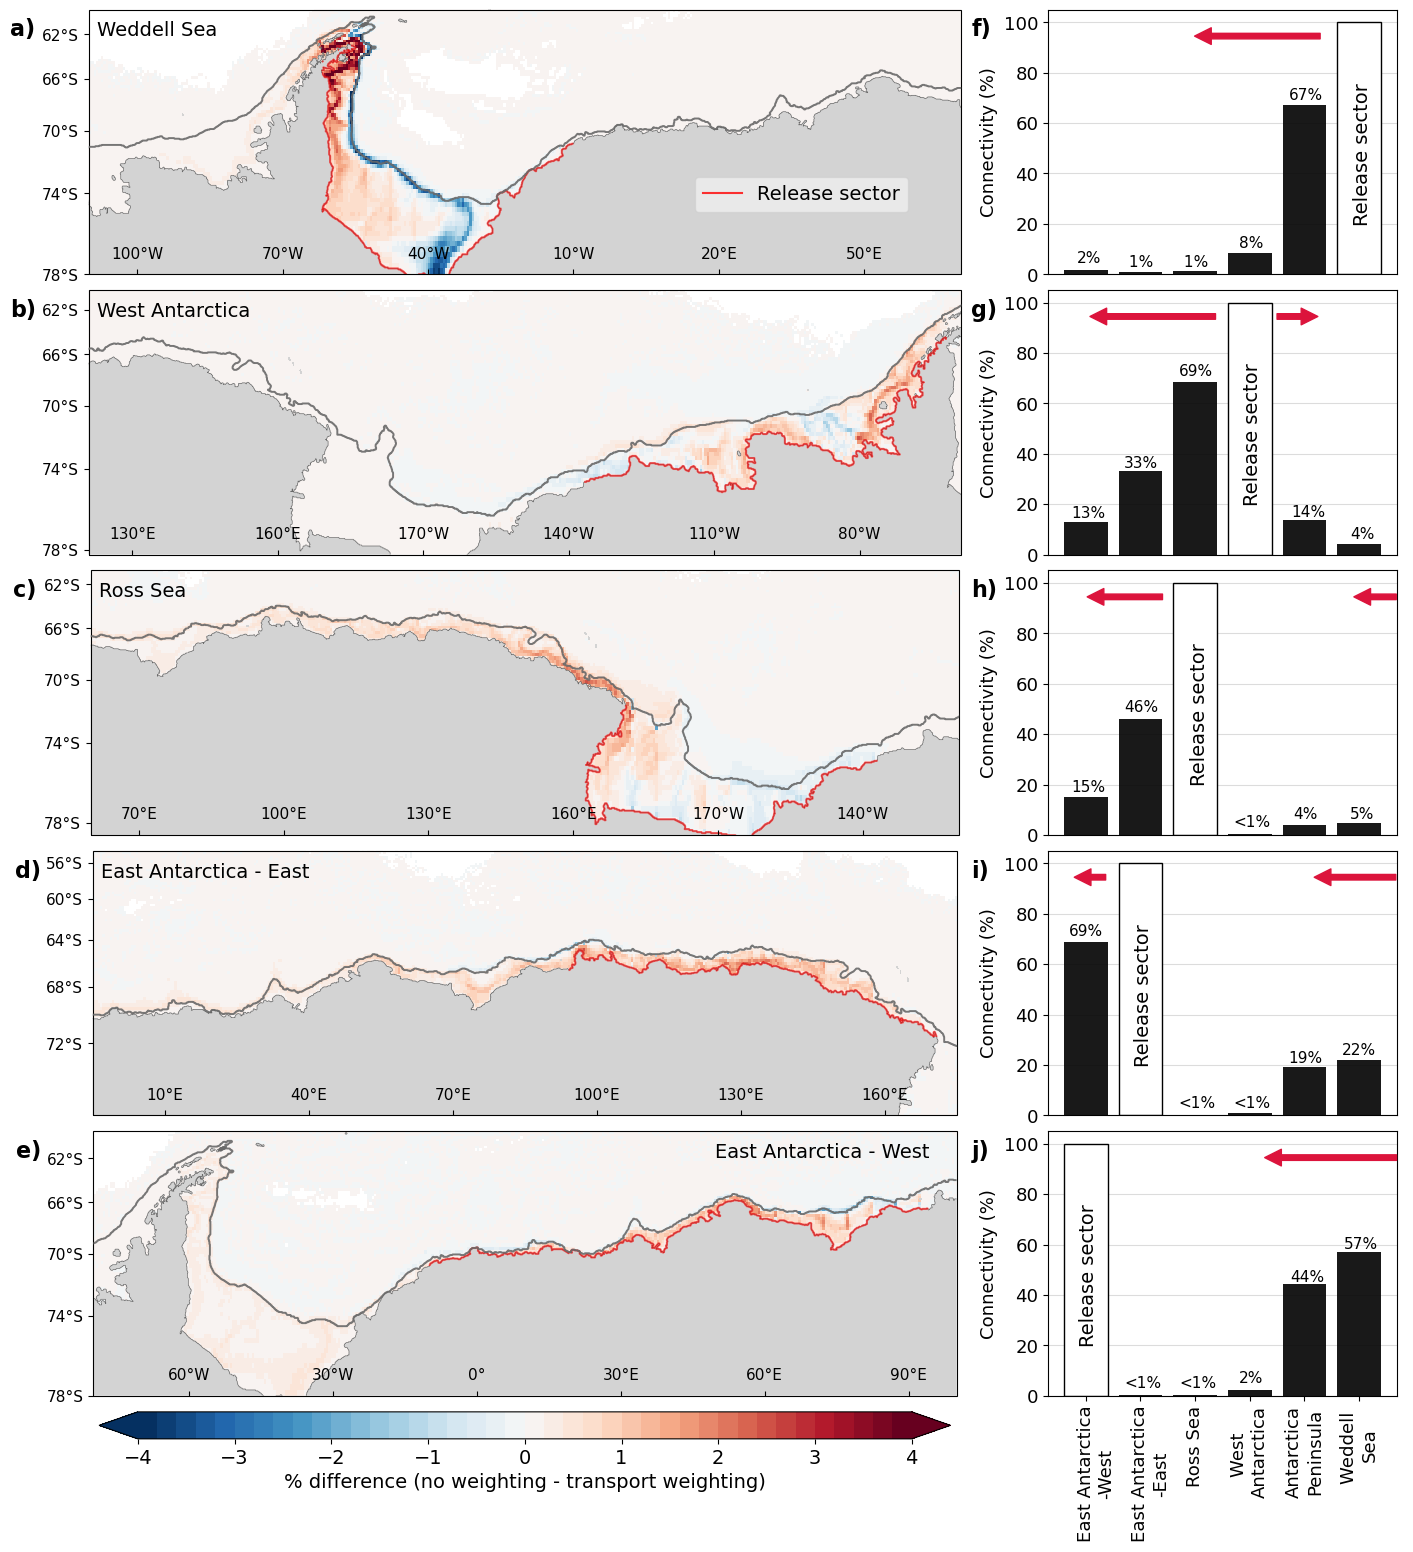

In [95]:
weight = 0  # weighting boolean to indicate transport weighting (or not)
            # 1 = particle count weighted by transport value to account for differing size of grid cells
            # 0 = simple particle count

fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = figure()

## Read in and plot data
# Subplot a) & f)----------------------------------------------------------------  
n = 5
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax1, ds)
plot_bars(ax2, data, n)

# Subplot b) & g)----------------------------------------------------------------  
n = 3
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax3, ds)
plot_bars(ax4, data, n)

# Subplot c) & h)----------------------------------------------------------------  
n = 2

ds = xr.open_dataset(files[n])
plot_pxy_diff(ax5, ds)
plot_bars(ax6, data, n)

# Subplot d) & i)----------------------------------------------------------------  
n = 1
ds = xr.open_dataset(files[n])
plot_pxy_diff(ax7, ds)
plot_bars(ax8, data, n)
    
# Subplot e) & j)---------------------------------------------------------------- 
n = 0
ds = xr.open_dataset(files[n])
p1 = plot_pxy_diff(ax9, ds)
plot_bars(ax10, data, n)

cbar = add_colorbar_diff(p1)
cbar.set_label('% difference (no weighting - transport weighting)', fontsize=14)#, rotation=270)


## Save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'sensitivityTest_Fig04_0.5x0.25map_noweight.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

In [88]:
for n in range(5):
    ds_mod = xr.open_dataset(sensitivity_files[n])
    ds = xr.open_dataset(files[n])
    print((ds.pxy_pct - ds.pxy_trans_pct).min().values,(ds.pxy_pct - ds.pxy_trans_pct).max().values)

-2.382640720145174 2.1325968582527652
-1.8001747251880973 2.5614399774201235
-2.047712678591198 2.4412592893007545
-1.499755022366191 2.474941635750076
-9.491005266162638 8.449932126214414
